In [19]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from tensorboardX import SummaryWriter
from toymeta.dark_room import DarkRoom
from tqdm import trange

from src.utils.custom_transforms import ComputeValueTargets, MergeTimeBatch
from utils.a2c import A2C, MLP_model, Policy
from src.utils.runners import EnvRunner
from src.utils.utils import visualize_policy
from src.utils.wrappers import make_parallel_env

plt.ioff()
from IPython.display import HTML
from IPython.display import Image

configure params:

In [2]:
NENVS = 10
SEED = 911

SIZE = 9
TERMINATE_ON_GOAL = True
RANDOM_START = False
GOAL = [0, 0]

HIDDEN_SIZE = 128
N_ACTIONS = 5

NSTEPS = 10

ENV_STEPS = 2_500_000
NUM_EPOCH = int(ENV_STEPS / NENVS / NSTEPS)
LR = 1e-4
BETA1 = 0.9
BETA2 = 0.999
EPS = 1e-6
VALUE_LOSS_COEF = 0.99
ENTROPY_COEF = 0.01

In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [4]:
env = make_parallel_env(
    nenvs=NENVS,
    seed=SEED,
    size=SIZE,
    terminate_on_goal=TERMINATE_ON_GOAL,
    random_start=RANDOM_START,
    goal=GOAL,
)
obs, _ = env.reset()

In [5]:
model = MLP_model(SIZE, GOAL, HIDDEN_SIZE, N_ACTIONS)
policy = Policy(model)

In [6]:
runner = EnvRunner(
    env,
    policy,
    nsteps=NSTEPS,
    transforms=[ComputeValueTargets(policy), MergeTimeBatch()],
)

In [7]:
opt = torch.optim.Adam(policy.model.parameters(), lr=LR, betas=(BETA1, BETA2), eps=EPS)
a2c = A2C(policy, opt, VALUE_LOSS_COEF, ENTROPY_COEF)

In [8]:
writer = SummaryWriter(f"logs/"+"_".join(map(str, GOAL)))

train:

In [9]:
for epoch in trange(NUM_EPOCH):
    trajectory = runner.get_next()

    data = a2c.step(trajectory)

    for stat_name in data:
        writer.add_scalar(f"train/{stat_name}", data[stat_name], runner.step_var)

100%|██████████| 25000/25000 [04:04<00:00, 102.21it/s]


evaluate:

In [18]:
visualize_policy(policy)

HTML("""
<video width="640" height="480" controls>
  <source src="src/videos/0_0.mp4" type="video/mp4">
</video>
""")

tensorboard screenshots:

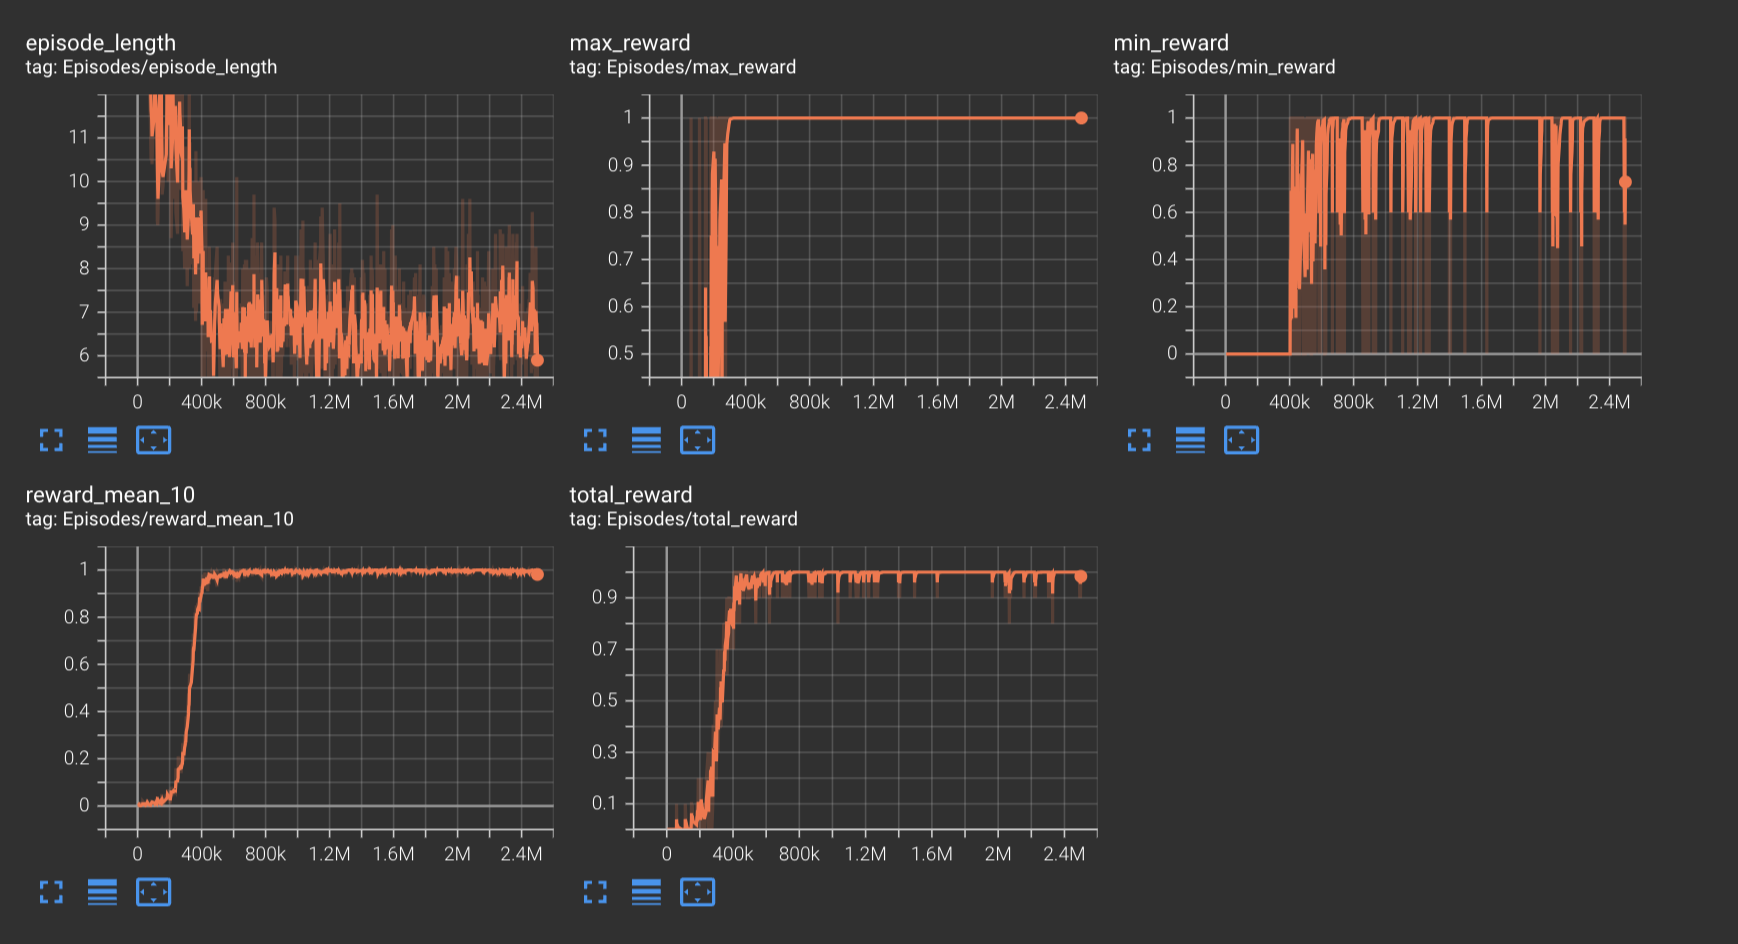

In [25]:
Image('tensorboard_img/env.png', width=800)

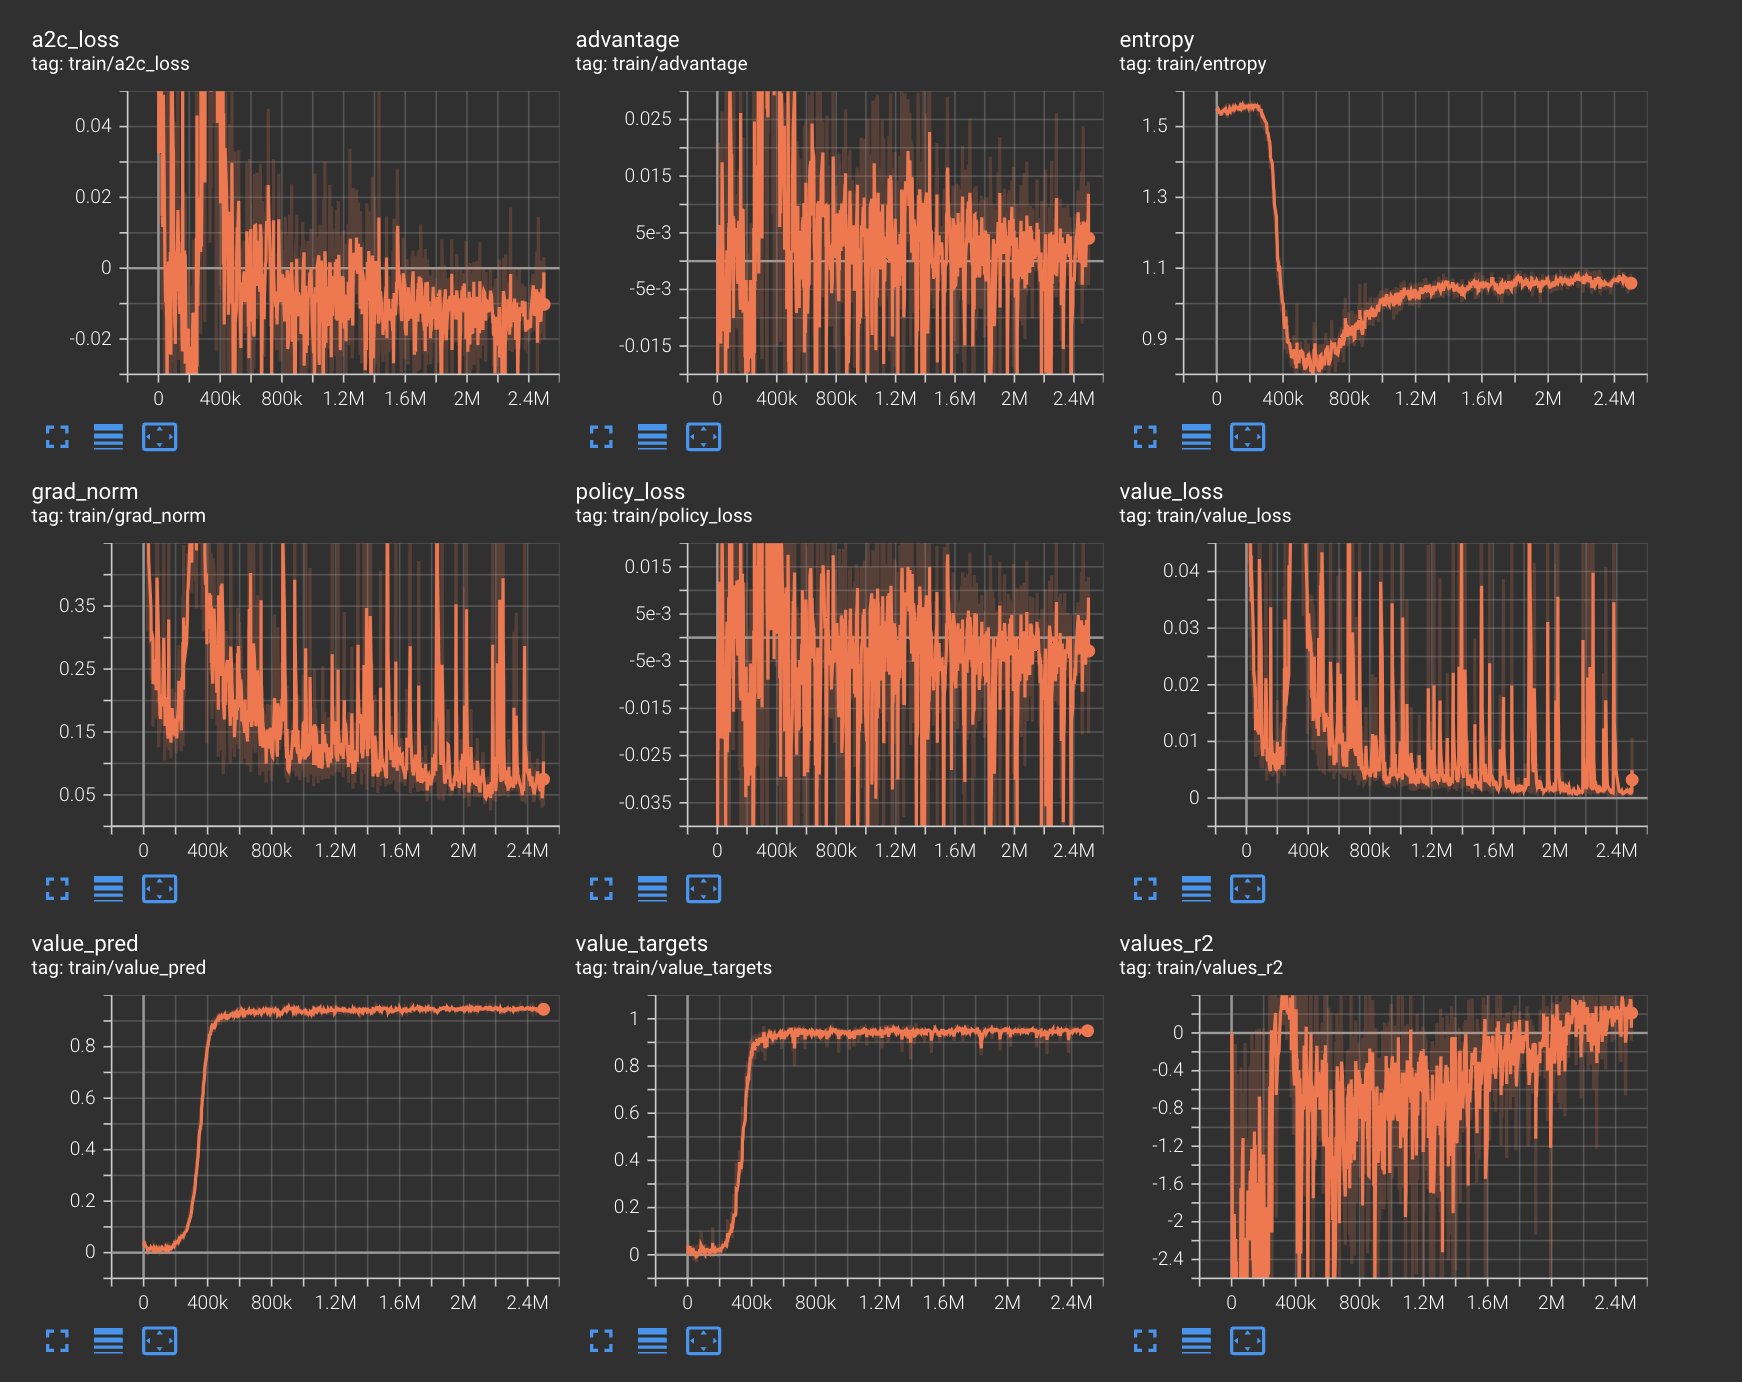

In [26]:
Image('tensorboard_img/train.png', width=800)